In [1]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *

In [2]:

print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images"))

['Uninfected', 'Parasitized']


In [3]:
path = Path("../input/cell-images-for-detecting-malaria/cell_images/cell_images")

In [4]:
path.ls()

(#2) [Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized')]

In [5]:
fns = get_image_files(path)

In [6]:
fns

(#27558) [Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C203ThinF_IMG_20151029_102123_cell_51.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C238NThinF_IMG_20151207_114038_cell_84.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C119P80ThinF_IMG_20151002_124304_cell_112.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C39P4thinF_original_IMG_20150622_111723_cell_33.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C101P62ThinF_IMG_20150918_151149_cell_63.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C180P141NThinF_IMG_20151201_165601_cell_115.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C95P56ThinF_IMG_20150821_171603_cell_75.png'),Path('../input/cell-images-for-detecting-malaria/cell_images/cell_im

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
cells = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
dls = cells.dataloaders(path)

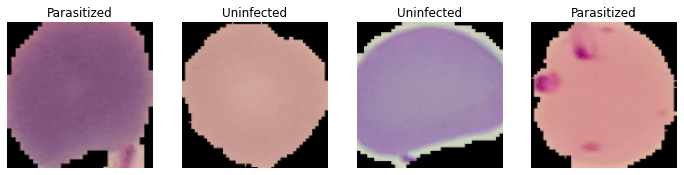

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

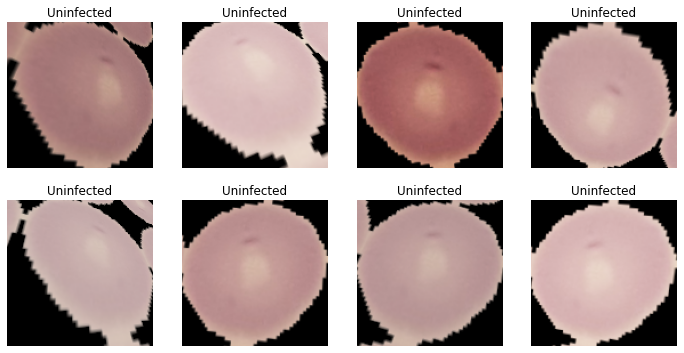

In [11]:
cells = cells.new(item_tfms=Resize(128, ResizeMethod.Squish), batch_tfms=aug_transforms(mult=2))
dls = cells.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique = True)

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.292457,0.209505,0.074215,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.161059,0.112155,0.042098,01:14
1,0.145770,0.106708,0.035384,01:14
2,0.124295,0.097708,0.031755,01:15
3,0.104116,0.090139,0.029577,01:14
4,0.092014,0.078770,0.027763,01:16
5,0.081871,0.079149,0.028670,01:25


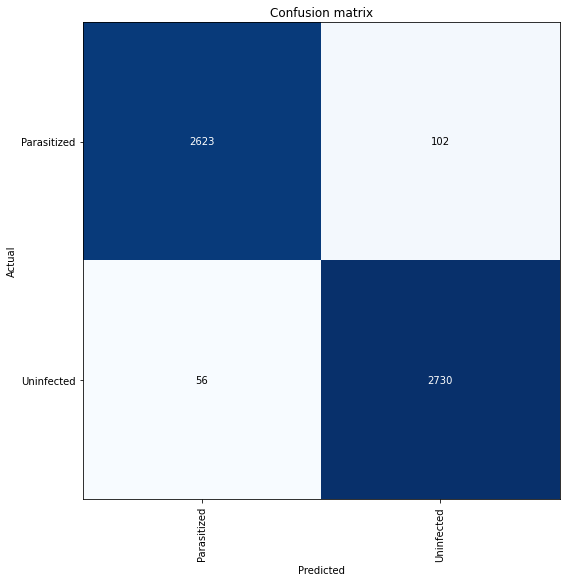

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

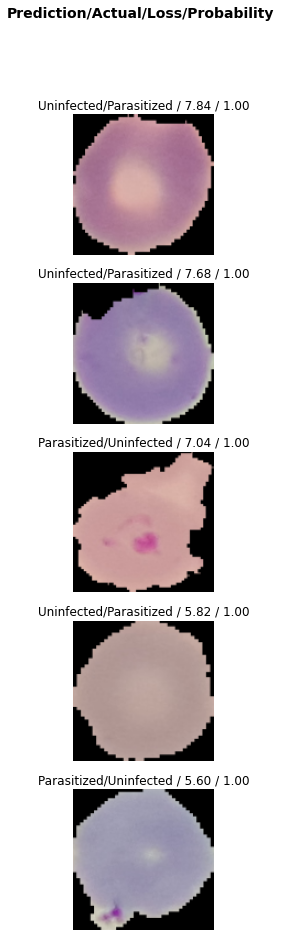

In [15]:
interp.plot_top_losses(5, nrows=5)

In [16]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [17]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([5511]), torch.Size([5511, 2]))

In [18]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((5511,), (5511,))

In [19]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report
classes = list(dls.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2725
  Uninfected       0.96      0.98      0.97      2786

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



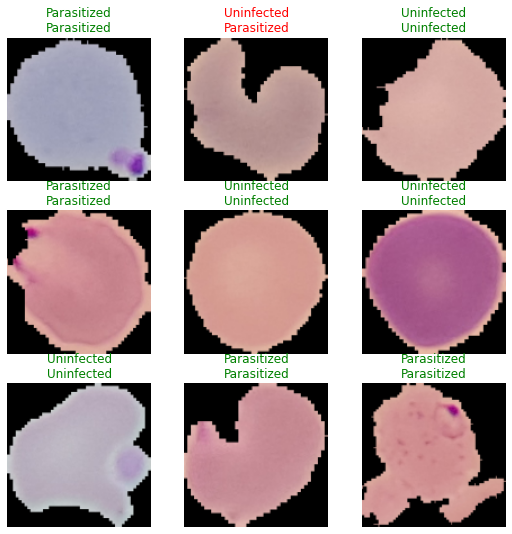

In [20]:
learn.show_results()